# Sentiment Classification & Embedding II

* Embedding Layer
* Sequence Model

# 01. What data we use?

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
url = 'https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/steam.txt'
data= pd.read_table(url, names=['label', 'reviews'])

In [ ]:
data.head()

,label,reviews
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요


In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=2021)
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

In [ ]:
train_data.shape, test_data.shape

((80000, 2), (20000, 2))

In [ ]:
test_data.head()

,label,reviews
0,0,절대로 사지마세요 님들아이거 사서 열심히 설치해서 해봤는데 멀티밖에 안되는 게임이 ...
1,1,조금 해봤는데 재미있네요
2,1,제작자가 행동 하나하나를 다 꿰뚫고있음 뭔 병신짓을 해도 다 받아줘서 좋음 10/10
3,1,길이길이 남을 대작 게임.설명하려 들고 싶지 않을 정도로 완벽 그자체. 꼭 해보세요!
4,0,한글문제인건지 실행은되나 리그 시작 자체가 안됨. 돈받고 파는거면 적어도 어떤 환경...


# Q1. Tokenizing & Text to Sequences

* 상위 40000개 단어만 사용한다.

In [ ]:
## 위의 한국어 전처리를 했다면 사용하지 않는다.
x_train = train_data['reviews'].astype('str').tolist()
x_test = test_data['reviews'].astype('str').tolist()

In [ ]:
y_train = train_data['label'].values
y_test = test_data['label'].values

In [ ]:
### Tokenizer here
from tensorflow.keras.preprocessing.text import Tokenizer
max_words = 40000 # 상위 40,000개의 단어만 보존
toknizer = Tokenizer(num_words=max_words, lower=False) # lower(대문자->소문자) 옵션은, 한국어 할 떄는 False

In [ ]:
#  Text --> Sequence
toknizer.fit_on_texts(x_train) # 토큰화
x_train = toknizer.texts_to_sequences(x_train) # text seq -> idx seq
x_test = toknizer.texts_to_sequences(x_test)

# Padding Sequence

* 문장의 최대 길이는 40으로 한다.

In [ ]:
max_words = max_words
embadding_dim = 128
max_len = 40 # 통일 할 문장 길이

In [ ]:
#### Pad Sequences here
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

In [ ]:
x_train = np.array(x_train)
x_test = np.array(x_test)

# 0으로 가득찬 데이터에 대한 추가 전처리

In [ ]:
not0train_idx = x_train.sum(1)>0
not0test_idx = x_test.sum(1)>0

In [ ]:
train_data = train_data.loc[not0train_idx].reset_index(drop=True)
test_data = test_data.loc[not0test_idx].reset_index(drop=True)

In [ ]:
x_train = x_train[not0train_idx]
y_train = y_train[not0train_idx]

x_test = x_test[not0test_idx]
y_test = y_test[not0test_idx]

# 모델링

**모델 구조**
1. 임베딩 레이어 : 임베딩차원은 128
2. Conv1D 블록 : 필터수 64개, 윈도우 사이즈 5
3. Bidirectional layer :
    * 정방향 : LSTM, 히든스테이트 32 
    * 역방향 : LSTM, 히든스테이트 32
4. Bidirectional layer :
    * 정방향 : GRU, 히든스테이트 32
    * 역방향 : RNN, 히든스테이트 16
5. Conv1D 블록 : 필터수 32개, 윈도우 사이즈 5
6. MaxPool1D 블록 : 필터사이즈2
7. 플래튼
8. FC Layer : 노드 1024개
9. 시그모이드 레이어

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPool1D, Input
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, SimpleRNN, GRU
from tensorflow.keras.models import Model

In [ ]:
# session clear
tf.keras.backend.clear_session()
# model
model = Model()
il = Input(shape=max_len)
# embadding - dim=128
hl = Embedding( max_words, embedding_dim )(il)
# conv1d f : 64 ,w : 5
hl = Conv1D(64, 5, activation='swish')(hl)
# Bidirectional : lstm 32, lstm 32 / gru 32, rnn 16
hl = Bidirectional(LSTM(32, return_sequences=True))(hl)

forward_layer = GRU(32, return_sequences=True)
backward_layer = SimpleRNN(16, return_sequences=True, go_backwards=True)
hl = Bidirectional(forward_layer, backward_layer=backward_layer)(hl)
# conv1d f:32 w:5
hl = Conv1D(filters=32, kernel_size=5)(hl)
# maxpool 1d : f_size 2
hl = MaxPool1D(2)(hl)
# flatten
hl = Flatten()(hl)
# fc layer 1024
hl = Dense(1024, activation='swish')(hl)
# output - sigmoid
ol = Dense(1, activation='sigmoid')(hl)
# Model
model = Model(il, ol)
# compile
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')
# summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40)]              0         
                                                                 
 embedding (Embedding)       (None, 40, 128)           4480000   
                                                                 
 conv1d (Conv1D)             (None, 36, 64)            41024     
                                                                 
 bidirectional (Bidirectiona  (None, 36, 64)           24832     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 36, 48)           10704     
 nal)                                                            
                                                                 
 conv1d_1 (Conv1D)           (None, 32, 32)            7712

# EarlyStopping을 이용한 학습.

1. 20%는 벨리데이션 셋.
2. 4epochs전과 비교하여 early stopping할 것.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=5,
                   verbose=1,
                   restore_best_weights=True)

In [ ]:
history = model.fit(x_train, y_train, epochs=100, validation_split=0.2, verbose =1,callbacks=[es])

Epoch 1/100
1895/1895 [==============================] - 134s 70ms/step - loss: 0.4452 - accuracy: 0.7910 - val_loss: 0.5043 - val_accuracy: 0.7667
Epoch 2/100
1895/1895 [==============================] - 104s 55ms/step - loss: 0.2861 - accuracy: 0.8753 - val_loss: 0.5897 - val_accuracy: 0.7355
Epoch 3/100
1895/1895 [==============================] - 107s 57ms/step - loss: 0.1810 - accuracy: 0.9219 - val_loss: 0.9470 - val_accuracy: 0.7296
Epoch 4/100
1895/1895 [==============================] - 105s 55ms/step - loss: 0.1328 - accuracy: 0.9424 - val_loss: 1.0899 - val_accuracy: 0.7256
Epoch 5/100
1895/1895 [==============================] - 108s 57ms/step - loss: 0.1082 - accuracy: 0.9508 - val_loss: 1.3078 - val_accuracy: 0.7113
Epoch 6/100
1895/1895 [==============================] - 106s 56ms/step - loss: 0.0944 - accuracy: 0.9562 - val_loss: 1.4986 - val_accuracy: 0.7286
Epoch 6: early stopping


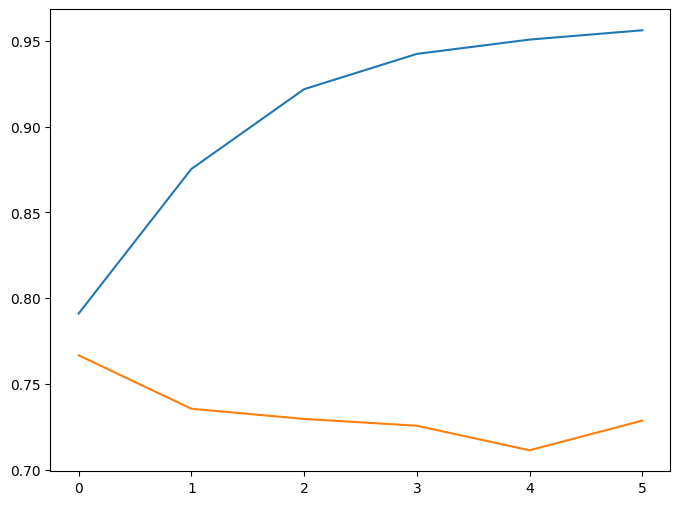

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [ ]:
model.evaluate(x_test, y_test)

591/591 [==============================] - 5s 9ms/step - loss: 0.5004 - accuracy: 0.7658


[0.500407338142395, 0.7658425569534302]

In [ ]:
review_idx = 128

temp = test_data.loc[review_idx]
docu = temp['reviews']
label = 'positive' if temp['label'] ==1 else 'Negative'

print(f"문서 번호 {review_idx}")
print(label, " : ", docu)
y_pred = model.predict(x_test[review_idx:review_idx+1])
label_pred = 'positive' if y_pred[0,0] >=0.5 else 'Negative'
print(f"모델의 예측 : {label_pred},   prob = {y_pred[0,0]*100:.2f}%")

문서 번호 128
positive  :  무료라서 좋아요
1/1 [==============================] - 0s 27ms/step
모델의 예측 : positive,   prob = 93.38%
